# Data Visualization of FBI Crime Data Agencies 

Author: Srinivasan Poonkundran

### Research Question:
How do agency types vary across different states in the USA, and what percentage of agencies in each
state participate in NIBRS reporting? Are there observable trends in NIBRS adoption over time?

### About dataset:

We’re looking at agency-level data across all 50 states in the USA. This dataset provides details on law enforcement agencies that have submitted data to the FBI’s Uniform Crime Reporting (UCR) Program and are displayed on the Crime Data Explorer (CDE).

The data we have is an agency level data across all the 50 states in United States. This data sets provides the details on law enforcement agencies that have submitted data to the FBI’s Uniform Crime Reporting Program and are displayed on the Crime Data Explorer. 

This dataset is a publicly available and sourced from TidyTuesday. It contains
information about agencies that have submitted data to the FBI’s Uniform Crime Reporting (UCR)
Program. Key variables include agency name, type, location (latitude/longitude, state, county), and
whether the agency participates in the National Incident-Based Reporting System (NIBRS), along
with the start date of NIBRS participation. 

Link to the dataset: https://github.com/rfordatascience/tidytuesday/tree/main/data/2025/2025-02-18

### Data Dictionary

#### agencies.csv

| Variable         | Type       | Description                                                                 |
|------------------|-----------|-----------------------------------------------------------------------------|
| ori              | character | Unique ID used to identify an agency.                                       |
| county           | character | The county associated with the agency’s jurisdiction within a state.        |
| latitude         | double    | The approximate latitude of the agency.                                     |
| longitude        | double    | The approximate longitude of the agency.                                    |
| state_abbr       | character | The abbreviated two-letter state code for the agency's location.            |
| state            | character | The full name of the state where the agency is located.                     |
| agency_name      | character | The official name of the agency.                                            |
| agency_type      | character | The type or category of the agency, such as city or county.                 |
| is_nibrs         | logical   | Indicates whether the agency participates in the FBI’s NIBRS program.       |
| nibrs_start_date | character | The date on which the agency began reporting data to NIBRS.                 |


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster

In [3]:
def count_null_vals(data):
    length = len(data)
    null_counts = data.isnull().sum()
    c = null_counts[null_counts > 0]
    xt = True
    for column, null_count in c.items():
        xt = False
        percent = (null_count/length) * 100
        print(f"'{column}' : {null_count} | {percent:.2f}%")
    if(xt):
        print("No Null values")

In [5]:
agencies = pd.read_csv('data/agencies.csv')
agencies.head()

,ori,county,latitude,longitude,state_abbr,state,agency_name,agency_type,is_nibrs,nibrs_start_date
0,AL0430200,LEE,32.604064,-85.353048,AL,Alabama,Opelika Police Department,City,True,2021-01-01
1,AL0430100,LEE,32.608086,-85.475136,AL,Alabama,Auburn Police Department,City,True,2020-12-01
2,AL0430000,LEE,32.604064,-85.353048,AL,Alabama,Lee County Sheriff's Office,County,True,2012-04-01
3,AL0070100,BIBB,33.015893,-87.127148,AL,Alabama,Centreville Police Department,City,True,2020-01-01
4,AL0070000,BIBB,32.939995,-87.116830,AL,Alabama,Bibb County Sheriff's Office,County,True,2021-01-01


In [6]:
agencies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19166 entries, 0 to 19165
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ori               19166 non-null  object 
 1   county            19166 non-null  object 
 2   latitude          17219 non-null  float64
 3   longitude         17219 non-null  float64
 4   state_abbr        19166 non-null  object 
 5   state             19166 non-null  object 
 6   agency_name       19166 non-null  object 
 7   agency_type       17491 non-null  object 
 8   is_nibrs          19166 non-null  bool   
 9   nibrs_start_date  15105 non-null  object 
dtypes: bool(1), float64(2), object(7)
memory usage: 1.3+ MB


In [7]:
agencies.describe()

,latitude,longitude
count,17219.000000,17219.000000
mean,38.431584,-88.965840
std,4.785443,13.303851
min,-9.000000,-164.188912
25%,34.933239,-95.268743
50%,39.214480,-86.135794
75%,41.717780,-80.198065
max,69.449343,178.338813


Les us now see if there are any null values in the data.

In [8]:
count_null_vals(agencies)

'latitude' : 1947 | 10.16%
'longitude' : 1947 | 10.16%
'agency_type' : 1675 | 8.74%
'nibrs_start_date' : 4061 | 21.19%


The above shows information on the missing values in the dataset. There are 1947 latitude and longitude data missing from the dataset, which is 10.16% of the data. Column 'agency_type' has 1675 missing values which is 8.74% of the total data. 21.19% of the data in 'nibrs_start_date' column is missing. These missing values will be handled in further section.

In [9]:
agencies['agency_type'].unique()

array(['City', 'County', 'University or College', nan, 'Other',
       'Other State Agency', 'Tribal', 'State Police', 'Unknown'],
      dtype=object)

In [10]:
agencies['agency_name'].unique()

array(['Opelika Police Department', 'Auburn Police Department',
       "Lee County Sheriff's Office", ...,
       'Thermopolis Police Department', 'Wyoming Highway Patrol',
       'Wind River Agency'], dtype=object)

Most of the data appears clean, except for missing values. We won’t need extensive data transformation.

### Handling Missing Values

There are two common approaches:

1. **Delete rows with missing values**  
   - Simple, but may reduce dataset size.
   - Suitable if missing data is minimal or random.

2. **Fill in missing values**  
   - Apply appropriate logic based on the variable.
   - Examples:
     - Use mean/median for numerical columns like `latitude` or `longitude`.
     - Use mode or "Unknown" for categorical columns like `county` or `agency_type`.


In [11]:
total_rows = agencies.shape[0]
missing_rows = agencies[agencies.isnull().any(axis=1)]
num_missing_rows = missing_rows.shape[0]
missing_percentage = (num_missing_rows / total_rows) * 100
print(f"Number of rows with missing values: {num_missing_rows}")
print(f"Percentage of rows with missing values: {missing_percentage:.2f}%")

Number of rows with missing values: 5524
Percentage of rows with missing values: 28.82%


If we use approach 1, we will have to drop 29% of the data which is a huge number. Hence let us go with option 2.

## Data Cleaning

Handle missing latitude/longitude values by imputing state averages.

In [12]:
#fill missing latitude/longitude with state averages
agencies['latitude'] = agencies.groupby('state_abbr')['latitude'].transform(lambda x: x.fillna(x.mean()))
agencies['longitude'] = agencies.groupby('state_abbr')['longitude'].transform(lambda x: x.fillna(x.mean()))

#remove invalid latitude entries
agencies = agencies[agencies['latitude'] > 0]

In [13]:
count_null_vals(agencies)

'agency_type' : 1675 | 8.74%
'nibrs_start_date' : 4061 | 21.19%


Classify agency types based on names (“Police” = City, “Sheriff” = County, others = Other).

In [14]:
#classify missing agency types
def classify_agency(name):
    if pd.isnull(name):
        return "Other"
    if "Sheriff" in name:
        return "County"
    if "Police" in name:
        return "City"
    return "Other"

agencies['agency_type'] = agencies.apply(
    lambda row: row['agency_type'] if pd.notnull(row['agency_type']) else classify_agency(row['agency_name']), axis=1)

In [15]:
count_null_vals(agencies)

'nibrs_start_date' : 4061 | 21.19%


Fill missing NIBRS start dates with median values.

In [16]:
# Fill missing nibrs_start_date with median
agencies['nibrs_start_date'] = pd.to_datetime(agencies['nibrs_start_date'], errors='coerce')
median_date = agencies['nibrs_start_date'].median()
agencies['nibrs_start_date'] = agencies['nibrs_start_date'].fillna(median_date)

In [17]:
count_null_vals(agencies)

No Null values


We have handled all the missing values.

## Exploratory Data Analysis (EDA)

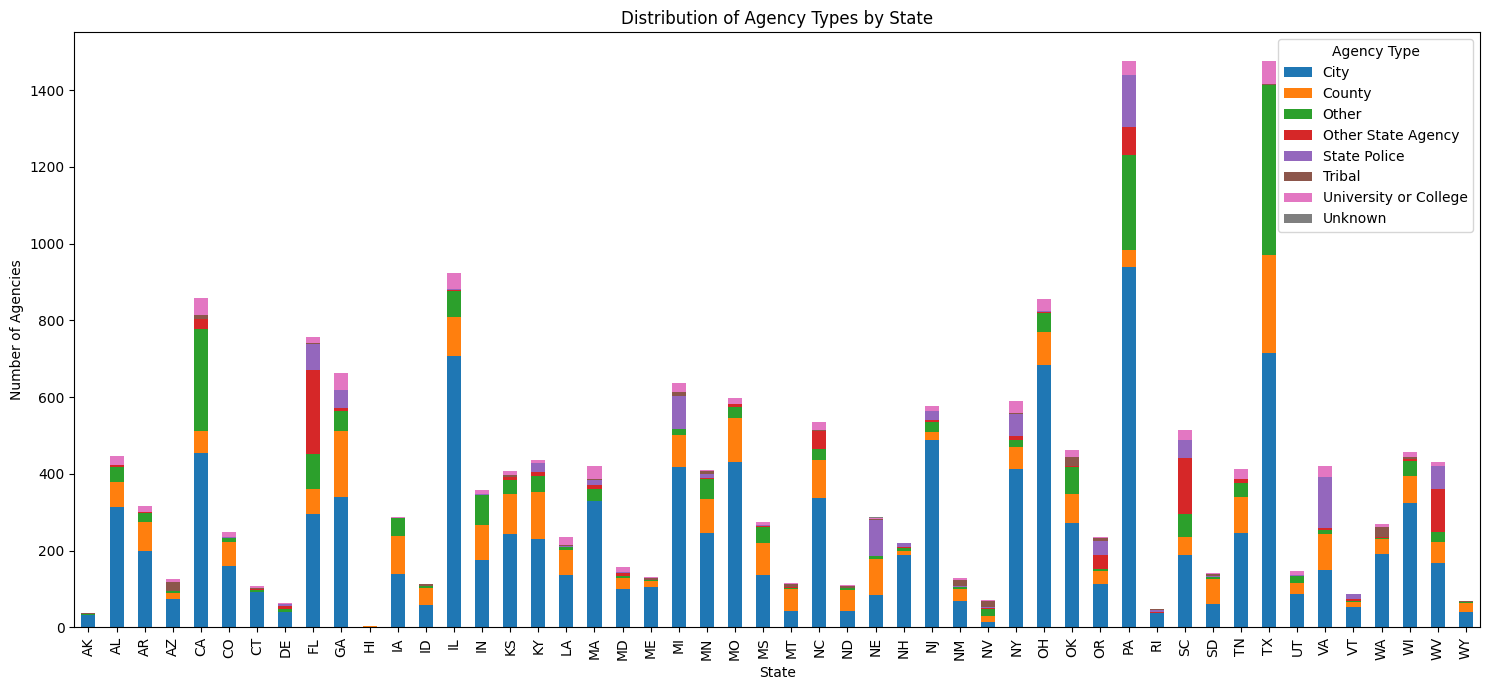

In [18]:
#distribution of agency types by state
agency_counts = agencies.groupby(['state_abbr', 'agency_type']).size().unstack(fill_value=0)
agency_counts.plot(kind='bar', stacked=True, figsize=(15, 7))
plt.title('Distribution of Agency Types by State')
plt.xlabel('State')
plt.ylabel('Number of Agencies')
plt.legend(title='Agency Type')
plt.tight_layout()
plt.show()

Follwoing is what we can see in the Distribution of Agency Types by State chart:

-   Most states have City agencies (like city police departments) as the biggest group.

-   County agencies (like sheriff offices) are the second most common.

-   There’s a smaller number labeled as Other, which could be special agencies or ones not clearly named.

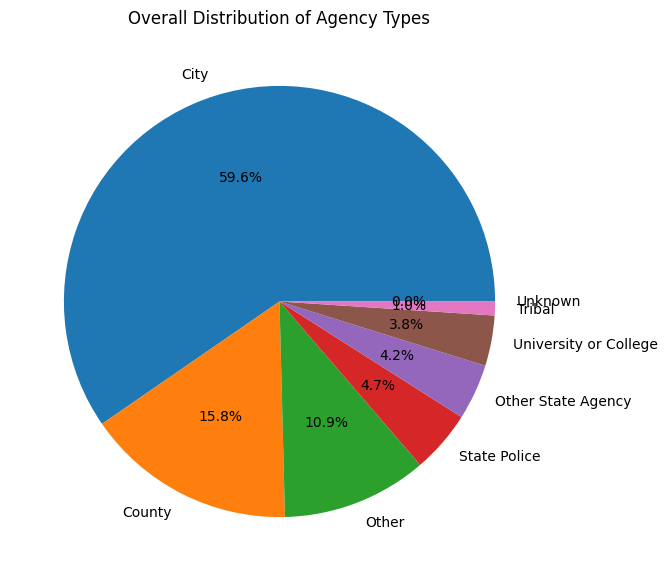

In [19]:
#overall agency type percentage
agency_type_counts = agencies['agency_type'].value_counts()
agency_type_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(7, 7))
plt.title('Overall Distribution of Agency Types')
plt.ylabel('')
plt.show()

Following is what we can see in the Overall Distribution of Agency Types chart:

-   City agencies make up the biggest slice of the pie. That means most law enforcement agencies in the U.S. are city-based, like local police departments.

-   County agencies are the next largest group, usually sheriff's offices serving bigger areas outside cities.

-   The smallest slice is labeled Other. These are special or unique agencies that don’t fit neatly into City or County categories.

When you look at the whole country, you see that law enforcement is mostly run by cities, followed by counties, and a small number fall into other types.

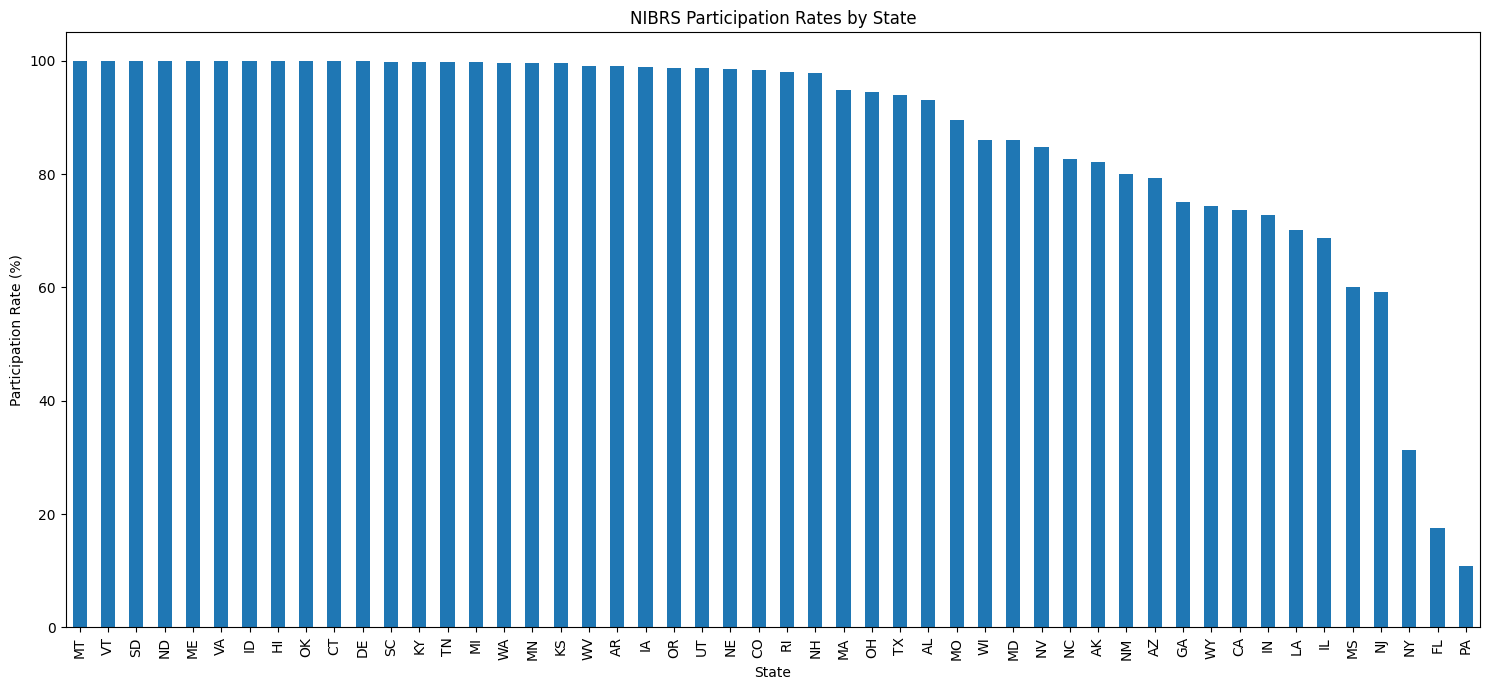

In [20]:
#NIBRS participation rates by state
nibrs_participation = agencies.groupby('state_abbr')['is_nibrs'].mean().sort_values(ascending=False) * 100
plt.figure(figsize=(15, 7))
nibrs_participation.plot(kind='bar')
plt.title('NIBRS Participation Rates by State')
plt.xlabel('State')
plt.ylabel('Participation Rate (%)')
plt.tight_layout()
plt.show()

Following is what can we see in the above plot:

-   Each bar shows how many agencies in a state report their crime data using the NIBRS system.

-   Most states have bars that almost reach 100%. That means nearly every agency in those states is using NIBRS.

-   Other states have much shorter bars, meaning fewer agencies are participating.

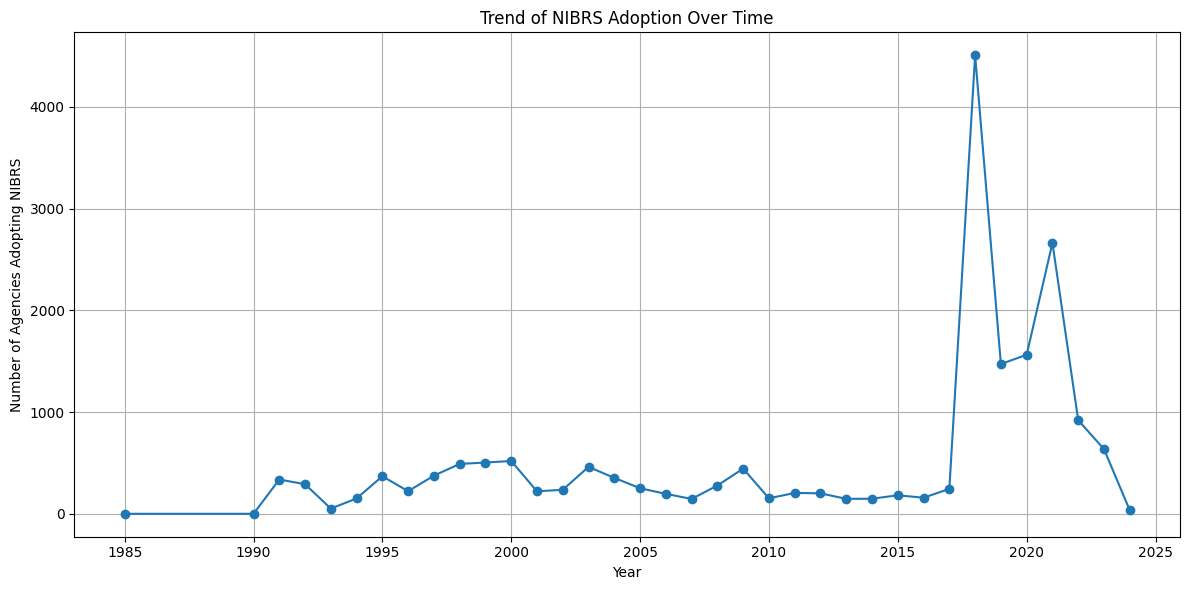

In [21]:
#trend of NIBRS adoption over time
nibrs_over_time = agencies['nibrs_start_date'].dt.year.value_counts().sort_index()
plt.figure(figsize=(12, 6))
nibrs_over_time.plot(kind='line', marker='o')
plt.title('Trend of NIBRS Adoption Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Agencies Adopting NIBRS')
plt.grid(True)
plt.tight_layout()
plt.show()

Following can be depicted from the above chart

-   The line shows how many agencies started using NIBRS each year.

-   In the early years, not many agencies joined—so the line stays low.

-   As time goes on, the line starts rising, meaning more agencies are adopting NIBRS.

There are a few years where the line jumps up sharply. That tells that something has happened. This could be new policies to get more agencies to report.
This shows steady growth, but not all agencies joined at once. It took time, and the adoption happened little by little.

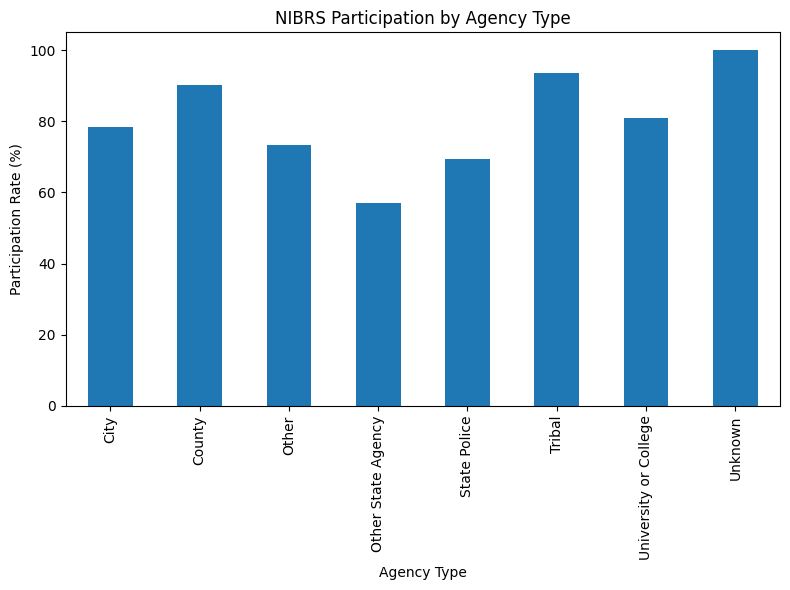

In [22]:
#correlation: Agency type vs NIBRS participation
participation_by_type = agencies.groupby('agency_type')['is_nibrs'].mean() * 100
participation_by_type.plot(kind='bar', figsize=(8, 6))
plt.title('NIBRS Participation by Agency Type')
plt.xlabel('Agency Type')
plt.ylabel('Participation Rate (%)')
plt.tight_layout()
plt.show()

Following is the information aquired from the above plot.

-   Each bar shows the percentage of agencies (by type) that are using NIBRS.

-   City agencies have the tallest bar. That means most city police departments are reporting their crime data through NIBRS.

-   County agencies have a lower bar, so fewer of them are participating compared to city agencies.

-   The Other agencies have the shortest bar, meaning the least participation.

City agencies are more likely to adopt NIBRS, while county and other agencies are slower to catch up.